# PRMS6 Surface BMI demo - Runtime interaction

* This demonstration will illustrate how the coupled surface- and soil-BMIs can be interacted with at runtime.
    * Some initial setup including matching an HRU polygon shapefile with order of HRUs in input file
    * Uisualizing results using by mapping onto geopandas dataframe
    * Using web-based data-services to drive climate forcing
    * User controled forcing to inspect HRU response


In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface, PRMSSoil
from pathlib import Path
import prms6bmi
import geopandas as gpd
import pandas as pd
from onhm import Onhm
import matplotlib.pyplot as plt
import matplotlib

➡ models: PRMSSurface, PRMSSoil


---
The next few slides read the the pipestem shapefile for use in plotting results below.
* The shapefile is filtered to include only the HRUs simulated
* The shapefile is reordered according to the ordering in the PRMS project
___

In [2]:
gdf = gpd.read_file('GIS/pipestem_hru_geographic.shp')
gdf.head()

,LAYER,hru_id_loc,hru_id,region,geometry
0,Unknown Area Type,2265,57848,r10u,"POLYGON ((-209834.804 2666444.996, -209835.087..."
1,Unknown Area Type,2267,57850,r10u,"MULTIPOLYGON (((-207734.972 2661663.705, -2077..."
2,Unknown Area Type,2270,57853,r10u,"POLYGON ((-210435.192 2666555.949, -210435.282..."
3,Unknown Area Type,2272,57855,r10u,"POLYGON ((-210855.095 2670974.953, -210884.836..."
4,Unknown Area Type,2273,57856,r10u,"POLYGON ((-218474.797 2677545.102, -218445.082..."


### Reorder shapefile according to order in PRMSSurface
* First - Create and Initialize the pipestem project and PRMSSurface model
* Second - Reorder shapefile for mapping model results onto HRU polygons

---


In [3]:
run_dir = '../prms/pipestem'
config_surf= 'control_surface.simple1'
config_soil = 'control_soil.simple1'
print(Path(run_dir).exists())
print((Path(run_dir) / config_surf).exists())
print((Path(run_dir) / config_soil).exists())
      
msurf = PRMSSurface()
msoil = PRMSSoil()

print(msurf.name, msoil.name)


True
True
True
prms6-surface-BMI prms6-BMI-SOIL


In [4]:
msurf.initialize(config_surf, run_dir)
msoil.initialize(config_soil, run_dir)
# m_surf.var['nowtime'].data

In [5]:
pd.set_option('mode.chained_assignment', None)
gdf_ps = gdf[gdf['hru_id'].isin(msurf.var['nhm_id'].data)]
print(type(msurf.var['nhm_id'].data))
dindex = np.zeros(np.shape(gdf_ps.hru_id.values), dtype=np.int8)
for index, val in np.ndenumerate(msurf.var['nhm_id'].data):
    tind = np.int(np.where(gdf_ps['hru_id'].values == msurf.var['nhm_id'].data[index])[0])
#     print(type(tind), tind)
    dindex[tind] = np.array([index])
print(dindex)
# # gdf_ps['tindex'] = 0
gdf_ps.loc[:,'tindex'] = dindex
# # # gdf_ps.Index.sort_values()
gdf_ps.sort_values(by=['tindex'], inplace=True)
gdf_ps
# # tmp = np.where(gdf_ps.hru_id.values == m.var['nhm_id'].data[0])
# # print(tmp[0])

<class 'numpy.ndarray'>
[12 13  4 10 11  5  0  1  2  6  7  3  8  9]


,LAYER,hru_id_loc,hru_id,region,geometry,tindex
14,Unknown Area Type,2291,57874,r10u,"POLYGON ((-240014.760 2709947.868, -240014.745...",0
15,Unknown Area Type,2292,57875,r10u,"POLYGON ((-241514.933 2720894.818, -241484.800...",1
16,Unknown Area Type,2295,57878,r10u,"POLYGON ((-263236.937 2720624.914, -263264.907...",2
19,Unknown Area Type,2298,57881,r10u,"POLYGON ((-263204.777 2722334.992, -263204.712...",3
10,Unknown Area Type,2285,57868,r10u,"POLYGON ((-237983.320 2707604.941, -237970.681...",4
13,Unknown Area Type,2290,57873,r10u,"MULTIPOLYGON (((-233025.091 2696955.163, -2330...",5
17,Unknown Area Type,2296,57879,r10u,"POLYGON ((-256485.222 2718105.125, -256455.090...",6
18,Unknown Area Type,2297,57880,r10u,"POLYGON ((-257828.084 2725785.089, -257827.820...",7
20,Unknown Area Type,2299,57882,r10u,"MULTIPOLYGON (((-245144.770 2725005.157, -2451...",8
21,Unknown Area Type,2300,57883,r10u,"POLYGON ((-255345.272 2728364.935, -255345.177...",9


--- 
Open climate file (daymet.nc) to inspect and plot the climate drivers

---

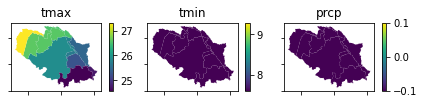

In [6]:
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
clim_file = Path('../prms/pipestem/daymet.nc')
clim = xr.open_dataset(clim_file)
ptime = msurf.var['nowtime'].data
timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
start_date = timesel
gdf_ps['tmax'] = clim.tmax.sel(time=timesel)
gdf_ps['tmin'] = clim.tmin.sel(time=timesel)
gdf_ps['prcp'] = clim.prcp.sel(time=timesel)
fig, ax = plt.subplots(ncols=3)
divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
divider2 = make_axes_locatable(ax[2])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
h_tmax = gdf_ps.tmax.max()
l_tmax = gdf_ps.tmax.min()
h_tmin= gdf_ps.tmin.max()
l_tmin= gdf_ps.tmin.min()
h_tmax = gdf_ps.tmax.max()
l_tmax = gdf_ps.tmax.min()
h_ppt= gdf_ps.prcp.max()
l_ppt= gdf_ps.prcp.min()

gdf_ps.plot(column='tmax', ax=ax[0], vmin=l_tmax, vmax=h_tmax, legend=True, label='tmax', cax=cax0)
gdf_ps.plot(column='tmin', ax=ax[1], vmin=l_tmin, vmax=l_tmin, legend=True, label='tmin', cax=cax1)
gdf_ps.plot(column='prcp', ax=ax[2], vmin=l_ppt, vmax=l_ppt, legend=True, label='prcp', cax=cax2)
for i in range(3):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    if i == 0:
        ax[i].set_title('tmax')
    elif i == 1:
        ax[i].set_title('tmin')
    elif i == 2:
        ax[i].set_title('prcp')
plt.tight_layout()

---

Search for an interesting period to inspect by looking at the cumulative precipitation

---

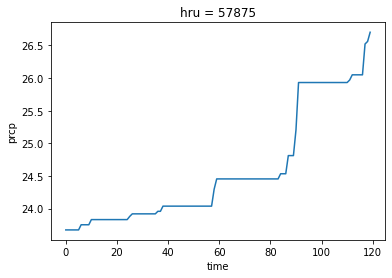

In [7]:
cum_sum= clim.cumsum(dim='time')
cum_sum.prcp.isel(hru=1)[365:485].plot()


---
Setup exhange between Surface- and Soil-BMIs

---

In [8]:
soil_input_cond_vars = ['soil_rechr_chg', 'soil_moist_chg']

soil_input_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv', 'dprst_evap_hru', 
                   'dprst_seep_hru', 'infil', 'sroff','potet', 'hru_intcpevap', 
                   'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max', 
                   'soil_moist', 'soil_moist_max', 'hru_impervevap' , 
                   'srunoff_updated_soil','transp_on']

soil2surf_vars = ['infil', 'sroff', 'soil_rechr', 'soil_moist']

def surface2soil(msurf, msoil, exch_vars, cond_vars, dprst_flag, imperv_flag):
    for var in exch_vars:
        msoil.set_value(var, msurf.get_value(var))
    if dprst_flag in [1, 3] or imperv_flag in [1, 3]:
        for var in cond_vars:
            msoil.set_value(var, msurf.get_value(var))

def soil2surface(msoil, msurf, exch_vars):
    for var in exch_vars:
        msurf.set_value(var, msoil.get_value(var))

---

Get some model time information

---

In [9]:
print(msurf.get_value('nowtime'))
print(msoil.var['nowtime'].data)

[1980    1    1    0    0    0]
[1980    1    1    0    0    0]


In [10]:
# Get time information from the model.
print(f'Start time Surface/Soil: {msurf.start_time}/{msoil.start_time}')
print(f'End time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print(f'Current time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print('Nowtime Surface/Soil:', msurf.var['nowtime'].data, msoil.var['nowtime'].data)

Start time Surface/Soil: 0.0/0.0
End time Surface/Soil: 731.0/731.0
Current time Surface/Soil: 731.0/731.0
Nowtime Surface/Soil: [1980    1    1    0    0    0] [1980    1    1    0    0    0]


---
Setup an exchange function to facilitate the coupling
___

In [11]:
dprst_flag = msoil.get_value('dyn_dprst_flag')
imperv_flag = msoil.get_value('dyn_imperv_flag')

def update_coupled(msurf, msoil, dprst_flag, imperv_flag):
    msurf.update()
    surface2soil(msurf, msoil, soil_input_vars, soil_input_cond_vars, dprst_flag, imperv_flag)
    msoil.update()
    soil2surface(msoil, msurf, soil2surf_vars)

---
Run for 1-year plus 83 days just prior to preciptation event in cumulative plot above

---

In [12]:
for time in range(448):
    update_coupled(msurf, msoil, dprst_flag, imperv_flag)

---
Build function to plot some variables at runtime:
* sroff: Surface runoff to the stream network for each HRU
* infil: Infiltration to the capillary reservoir for each HRU
* soil_moist_tot: Total soil-zone storage (soil_moist + ssres_stor) for each HRU

---

In [13]:
def example_plot(msurf, msoil, j, timesel):
    gdf_ps['tmax'] = clim.tmax.sel(time=timesel)
    gdf_ps['tmin'] = clim.tmin.sel(time=timesel)
    gdf_ps['prcp'] = clim.prcp.sel(time=timesel)

    gdf_ps['infil'] = msurf.var['infil'].data
    gdf_ps['sroff'] = msurf.var['sroff'].data
    gdf_ps['soil_moist_tot'] = msoil.var['soil_moist_tot'].data

    fig, ax = plt.subplots(ncols=6, figsize = (12,2))
    divider0 = make_axes_locatable(ax[0])
    divider1 = make_axes_locatable(ax[1])
    divider2 = make_axes_locatable(ax[2])
    divider3 = make_axes_locatable(ax[3])
    divider4 = make_axes_locatable(ax[4])
    divider5 = make_axes_locatable(ax[5])
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    cax5 = divider5.append_axes("right", size="5%", pad=0.1)
    
    gdf_ps.plot(column='tmax', vmin=20.0, vmax=65.0, ax=ax[0], legend=True, cax=cax0)
    gdf_ps.plot(column='tmin', vmin=20.0, vmax=65.0, ax=ax[1], legend=True, cax=cax1)
    gdf_ps.plot(column='prcp', vmin=0.0, vmax=0.7, ax=ax[2], legend=True, cax=cax2)
    gdf_ps.plot(column='infil', vmin=0.0, vmax=0.7, ax=ax[3], legend=True, cax=cax3)
    gdf_ps.plot(column='sroff', vmin=0.0, vmax=0.25, ax=ax[4], legend=True, cax=cax4)
    gdf_ps.plot(column='soil_moist_tot', vmin=0.25, vmax=1.75, ax=ax[5], legend=True, cax=cax5)
    for i in range(6):
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        if j == 0:
            if i == 0:
                ax[i].set_title('tmax')
            elif i == 1:
                ax[i].set_title('tmin')
            elif i == 2:
                ax[i].set_title('prcp')
            elif i == 3:
                ax[i].set_title('infil')
            elif i == 4:
                ax[i].set_title('sroff')
            elif i == 5:
                ax[i].set_title('soil_moist_tot')
    plt.tight_layout()
    


---
Run for 14-days and inspect results

---

[1981    3   24    0    0    0] 1981-03-24 00:00:00
[1981    3   25    0    0    0] 1981-03-25 00:00:00
[1981    3   26    0    0    0] 1981-03-26 00:00:00
[1981    3   27    0    0    0] 1981-03-27 00:00:00
[1981    3   28    0    0    0] 1981-03-28 00:00:00
[1981    3   29    0    0    0] 1981-03-29 00:00:00
[1981    3   30    0    0    0] 1981-03-30 00:00:00
[1981    3   31    0    0    0] 1981-03-31 00:00:00
[1981    4    1    0    0    0] 1981-04-01 00:00:00
[1981    4    2    0    0    0] 1981-04-02 00:00:00
[1981    4    3    0    0    0] 1981-04-03 00:00:00
[1981    4    4    0    0    0] 1981-04-04 00:00:00
[1981    4    5    0    0    0] 1981-04-05 00:00:00
[1981    4    6    0    0    0] 1981-04-06 00:00:00


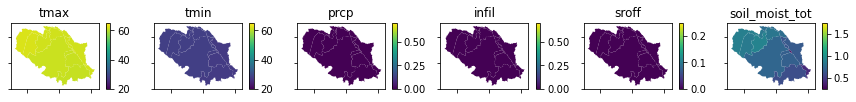

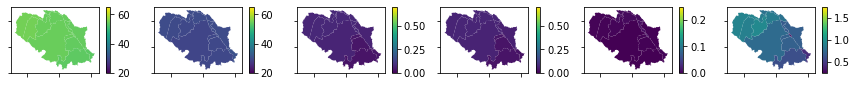

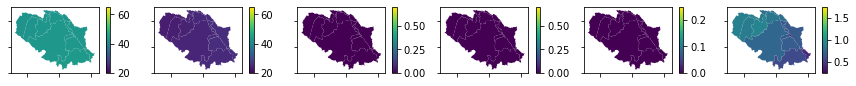

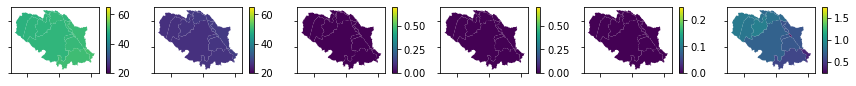

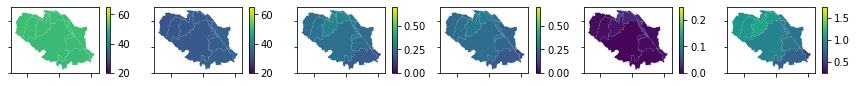

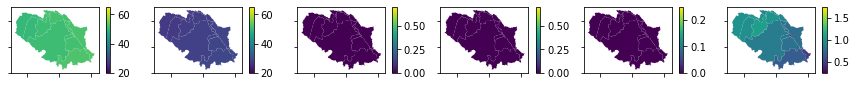

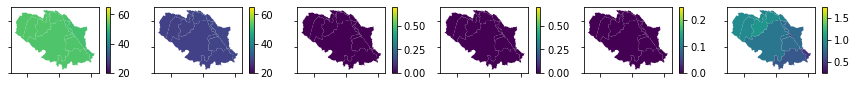

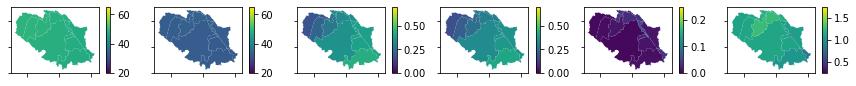

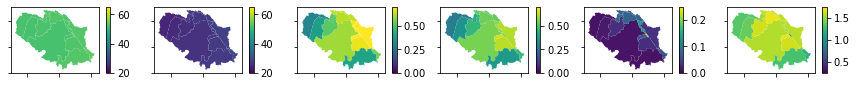

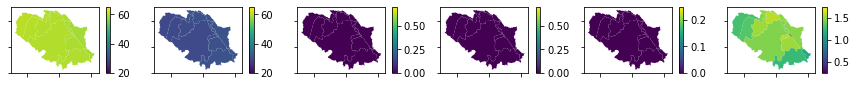

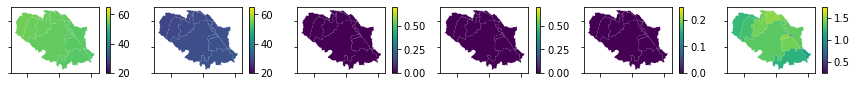

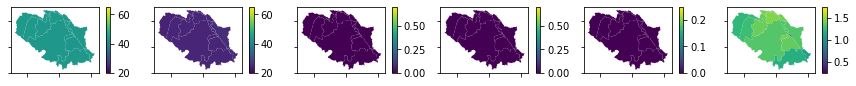

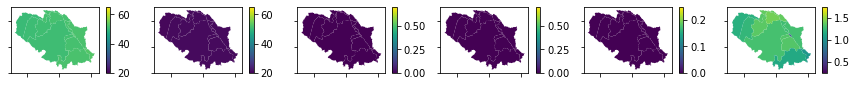

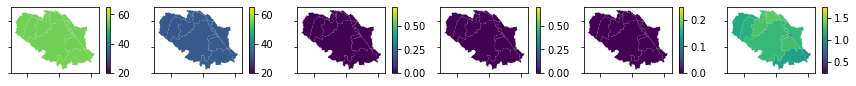

In [14]:
for i in range(14):
    update_coupled(msurf, msoil, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
    example_plot(msurf, msoil, i, timesel)

In [15]:
for i in range(14):
    update_coupled(msurf, msoil, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
#     example_plot(msurf, msoil, i, timesel)

[1981    4    7    0    0    0] 1981-04-07 00:00:00
[1981    4    8    0    0    0] 1981-04-08 00:00:00
[1981    4    9    0    0    0] 1981-04-09 00:00:00
[1981    4   10    0    0    0] 1981-04-10 00:00:00
[1981    4   11    0    0    0] 1981-04-11 00:00:00
[1981    4   12    0    0    0] 1981-04-12 00:00:00
[1981    4   13    0    0    0] 1981-04-13 00:00:00
[1981    4   14    0    0    0] 1981-04-14 00:00:00
[1981    4   15    0    0    0] 1981-04-15 00:00:00
[1981    4   16    0    0    0] 1981-04-16 00:00:00
[1981    4   17    0    0    0] 1981-04-17 00:00:00
[1981    4   18    0    0    0] 1981-04-18 00:00:00
[1981    4   19    0    0    0] 1981-04-19 00:00:00
[1981    4   20    0    0    0] 1981-04-20 00:00:00


### Drive climate forcing with web-based data services - here Gridmet
* Pull Gridmet data from web-service for specified period and map to HRUs

In [16]:
print(msurf.get_value('nowtime'))

[1981    4   20    0    0    0]


In [17]:
wght = '../../onhm-fetcher-parser/Data/weights.csv'
gmdata = Onhm("1981-04-21", end_date="1981-05-04", map=True, hru_id=msurf.get_value('nhm_id'), wght_file=wght)

[1981    4   21    0    0    0] 1981-04-21 00:00:00
[1981    4   22    0    0    0] 1981-04-22 00:00:00
[1981    4   23    0    0    0] 1981-04-23 00:00:00
[1981    4   24    0    0    0] 1981-04-24 00:00:00
[1981    4   25    0    0    0] 1981-04-25 00:00:00
[1981    4   26    0    0    0] 1981-04-26 00:00:00
[1981    4   27    0    0    0] 1981-04-27 00:00:00
[1981    4   28    0    0    0] 1981-04-28 00:00:00
[1981    4   29    0    0    0] 1981-04-29 00:00:00
[1981    4   30    0    0    0] 1981-04-30 00:00:00
[1981    5    1    0    0    0] 1981-05-01 00:00:00
[1981    5    2    0    0    0] 1981-05-02 00:00:00
[1981    5    3    0    0    0] 1981-05-03 00:00:00
[1981    5    4    0    0    0] 1981-05-04 00:00:00


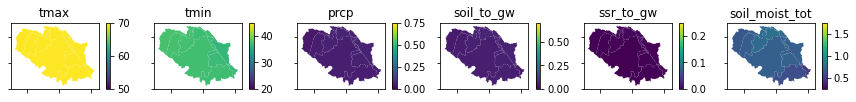

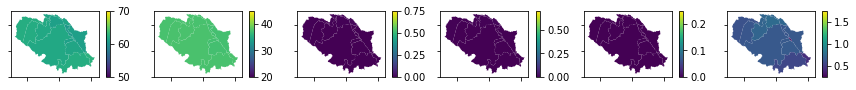

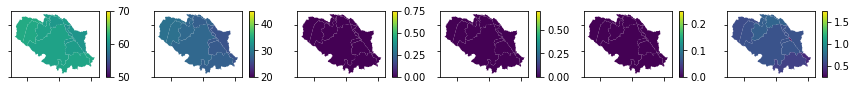

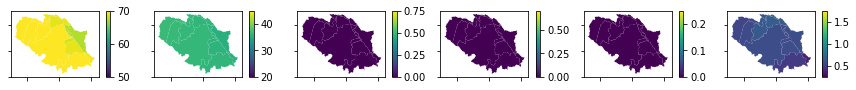

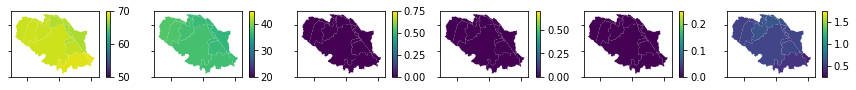

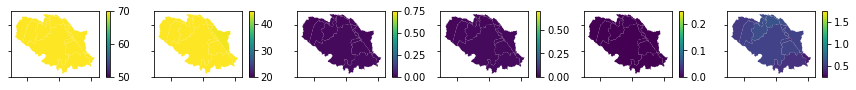

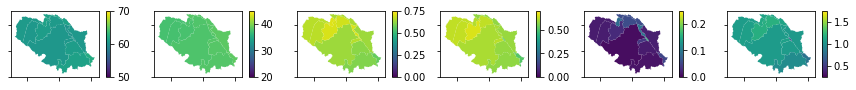

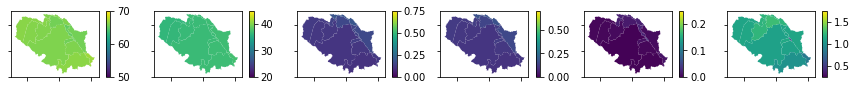

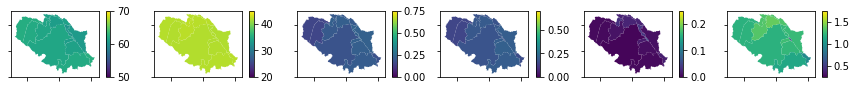

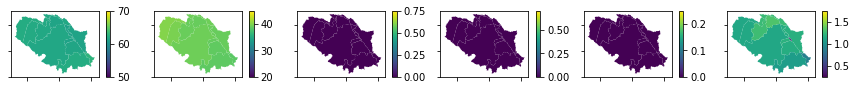

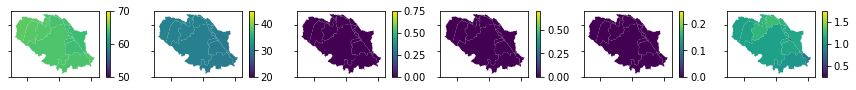

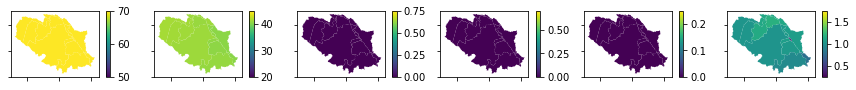

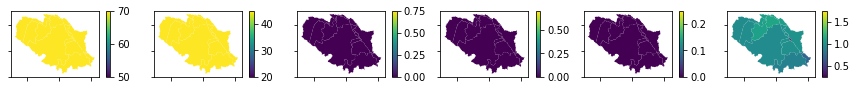

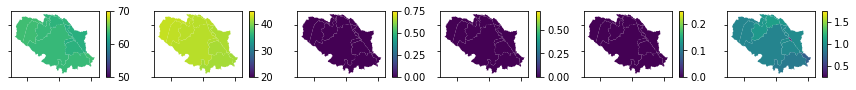

In [18]:
def gm_example_plot(msurf, msoil, gmdata, j, timesel):
    gdf_ps['tmax'] = (gmdata.tmax.data[j,:]*(9/5))+32.0
    gdf_ps['tmin'] = (gmdata.tmin.data[j,:]*(9/5))+32.0
    gdf_ps['prcp'] = gmdata.precip.data[j,:]*.0393701
#     print(gmdata.precip[j,:]*.0393701)
#     print(msurf.var['tmax'].data)
#     print(msurf.var['tmin'].data)
#     print(msurf.get_value('hru_ppt'))

    gdf_ps['infil'] = msurf.var['infil'].data
    gdf_ps['sroff'] = msurf.var['sroff'].data
    gdf_ps['soil_moist_tot'] = msoil.var['soil_moist_tot'].data

    fig, ax = plt.subplots(ncols=6, figsize = (12,2))
    divider0 = make_axes_locatable(ax[0])
    divider1 = make_axes_locatable(ax[1])
    divider2 = make_axes_locatable(ax[2])
    divider3 = make_axes_locatable(ax[3])
    divider4 = make_axes_locatable(ax[4])
    divider5 = make_axes_locatable(ax[5])
#     divider6 = make_axes_locatable(ax[6])
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    cax5 = divider5.append_axes("right", size="5%", pad=0.1)
#     cax6 = divider6.append_axes("right", size="5%", pad=0.1)
    
    gdf_ps.plot(column='tmax', vmin=50.0, vmax=70.0, ax=ax[0], legend=True, cax=cax0)
    gdf_ps.plot(column='tmin', vmin=20.0, vmax=45.0, ax=ax[1], legend=True, cax=cax1)
    gdf_ps.plot(column='prcp', vmin=0.0, vmax=.75, ax=ax[2], legend=True, cax=cax2)
    gdf_ps.plot(column='infil', vmin=0.0, vmax=0.7, ax=ax[3], legend=True, cax=cax3)
    gdf_ps.plot(column='sroff', vmin=0.0, vmax=0.25, ax=ax[4], legend=True, cax=cax4)
    gdf_ps.plot(column='soil_moist_tot', vmin=0.25, vmax=1.75, ax=ax[5], legend=True, cax=cax5)
#     gdf_ps.plot(column='soil_moist_tot', vmin=0.0, vmax=1.5, ax=ax[6], legend=True, cax=cax6)
    for i in range(6):
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        if j == 0:
            if i == 0:
                ax[i].set_title('tmax')
            elif i == 1:
                ax[i].set_title('tmin')
            elif i == 2:
                ax[i].set_title('prcp')
            elif i == 3:
                ax[i].set_title('soil_to_gw')
            elif i == 4:
                ax[i].set_title('ssr_to_gw')
            elif i == 5:
                ax[i].set_title('soil_moist_tot')
#             elif i == 6:
#                 ax[i].set_title('soil_moist_tot')
    plt.tight_layout()
    
for i in np.arange(14):
    tmp_p = msurf.get_value('hru_ppt')
    tmp_tmax = msurf.get_value('tmax')
    tmp_tmin = msurf.get_value('tmin')
    tmp_p[:] = gmdata.precip.data[i,:]*.0393701
    tmp_tmax[:] = (gmdata.tmax.data[i,:]*(9./5.))+32.0
    tmp_tmin[:] = (gmdata.tmin.data[i,:]*(9./5.))+32.0
    msurf.set_value('hru_ppt', tmp_p)
    msurf.set_value('tmax', tmp_tmax)
    msurf.set_value('tmin', tmp_tmin)
#     print(gmdata.precip[i,:]*.0393701)
#     print((gmdata.tmax[i,:]*(9/5))+32.0)
#     print((gmdata.tmin[i,:]*(9/5))+32.0)    
    update_coupled(msurf, msoil, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
#     print(gmdata.precip.data[i,:]*.0393701)
    gm_example_plot(msurf, msoil, gmdata, i, timesel)

---
In the next cell the precipitation, normally read from the netCDF file is overridden with user defined values.  Here we kick one HRU with a large amount of precipt, 3", and view the response

---

In [19]:
nhm_id = msurf.get_value('nhm_id')
print(nhm_id, type(nhm_id))
ppt_override = msurf.get_value('hru_ppt')
ppt_override[:]= 0.0
ppt_override[0] = 3
ppt_override

[57874 57875 57878 57881 57868 57873 57879 57880 57882 57883 57869 57870
 57864 57865] <class 'numpy.ndarray'>


array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

---
Note that the prcp value plotted below is the from the climate dataset not the value 'hru_ppt' that we are forcing

---

[1981    5    5    0    0    0] 1981-05-05 00:00:00
[1981    5    6    0    0    0] 1981-05-06 00:00:00
[1981    5    7    0    0    0] 1981-05-07 00:00:00
[1981    5    8    0    0    0] 1981-05-08 00:00:00
[1981    5    9    0    0    0] 1981-05-09 00:00:00
[1981    5   10    0    0    0] 1981-05-10 00:00:00
[1981    5   11    0    0    0] 1981-05-11 00:00:00
[1981    5   12    0    0    0] 1981-05-12 00:00:00
[1981    5   13    0    0    0] 1981-05-13 00:00:00
[1981    5   14    0    0    0] 1981-05-14 00:00:00
[1981    5   15    0    0    0] 1981-05-15 00:00:00
[1981    5   16    0    0    0] 1981-05-16 00:00:00
[1981    5   17    0    0    0] 1981-05-17 00:00:00
[1981    5   18    0    0    0] 1981-05-18 00:00:00


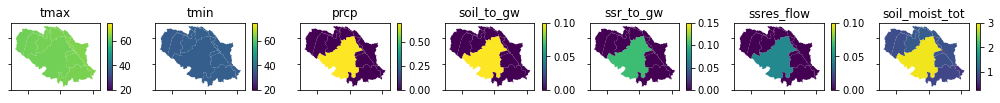

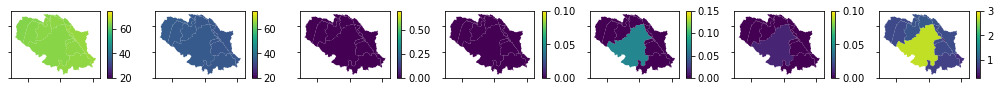

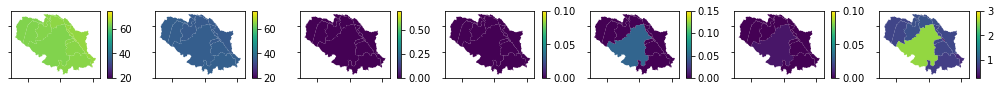

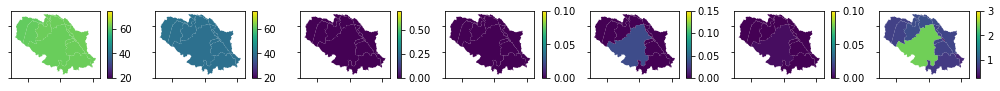

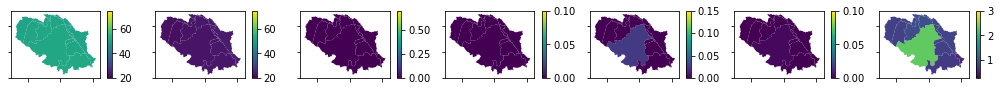

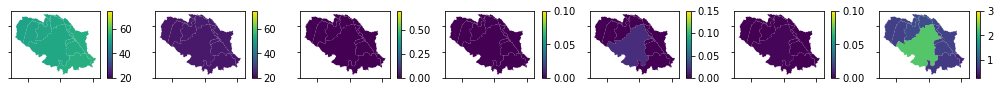

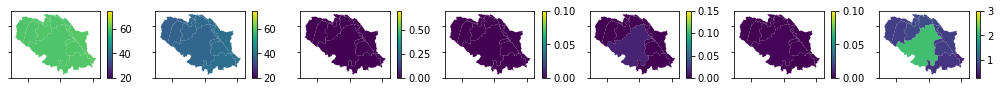

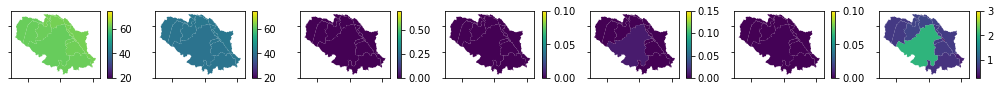

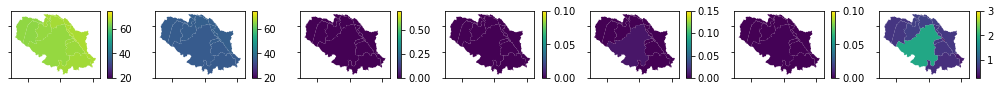

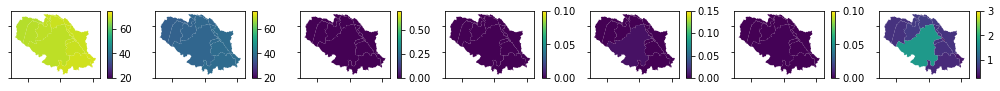

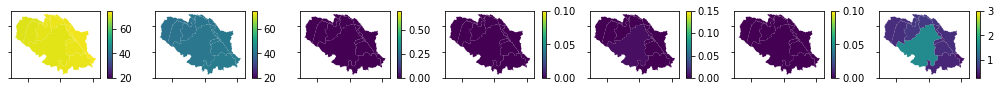

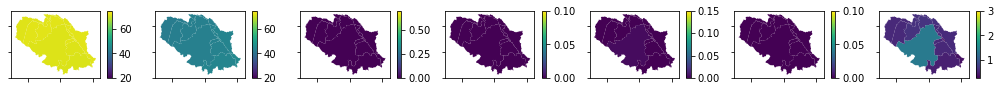

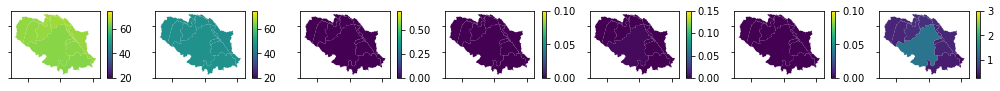

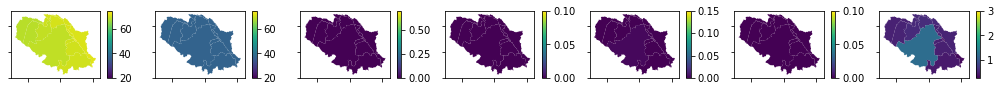

In [20]:
def example_plot(msurf, msoil, j, timesel):
    gdf_ps['tmax'] = (msurf.get_value('tmax')*(9.0/5.0)) + 32.0
    gdf_ps['tmin'] = (msurf.get_value('tmin')*(9.0/5.0)) + 32.0
    gdf_ps['prcp'] = msurf.get_value('hru_ppt')

    gdf_ps['soil_to_gw'] = msoil.var['soil_to_gw'].data
    gdf_ps['ssr_to_gw'] = msoil.var['ssr_to_gw'].data
    gdf_ps['ssres_flow'] = msoil.var['ssres_flow'].data
    gdf_ps['soil_moist_tot'] = msoil.var['soil_moist_tot'].data

    fig, ax = plt.subplots(ncols=7, figsize = (14,2))
    divider0 = make_axes_locatable(ax[0])
    divider1 = make_axes_locatable(ax[1])
    divider2 = make_axes_locatable(ax[2])
    divider3 = make_axes_locatable(ax[3])
    divider4 = make_axes_locatable(ax[4])
    divider5 = make_axes_locatable(ax[5])
    divider6 = make_axes_locatable(ax[6])
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    cax5 = divider5.append_axes("right", size="5%", pad=0.1)
    cax6 = divider6.append_axes("right", size="5%", pad=0.1)
    
    gdf_ps.plot(column='tmax', vmin=20.0, vmax=75.0, ax=ax[0], legend=True, cax=cax0)
    gdf_ps.plot(column='tmin', vmin=20.0, vmax=75.0, ax=ax[1], legend=True, cax=cax1)
    gdf_ps.plot(column='prcp', vmin=0.0, vmax=0.7, ax=ax[2], legend=True, cax=cax2)
    gdf_ps.plot(column='soil_to_gw', vmin=0.0, vmax=0.1, ax=ax[3], legend=True, cax=cax3)
    gdf_ps.plot(column='ssr_to_gw', vmin=0.0, vmax=0.15, ax=ax[4], legend=True, cax=cax4)
    gdf_ps.plot(column='ssres_flow', vmin=0.0, vmax=0.1, ax=ax[5], legend=True, cax=cax5)
    gdf_ps.plot(column='soil_moist_tot', vmin=0.25, vmax=3.0, ax=ax[6], legend=True, cax=cax6)
    for i in range(7):
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        if j == 0:
            if i == 0:
                ax[i].set_title('tmax')
            elif i == 1:
                ax[i].set_title('tmin')
            elif i == 2:
                ax[i].set_title('prcp')
            elif i == 3:
                ax[i].set_title('soil_to_gw')
            elif i == 4:
                ax[i].set_title('ssr_to_gw')
            elif i == 5:
                ax[i].set_title('ssres_flow')
            elif i == 6:
                ax[i].set_title('soil_moist_tot')
    plt.tight_layout()
    
for i in range(14):
    if i == 0:
        ppt_override = msurf.get_value('hru_ppt')
        ppt_override[:]= 0.0
        ppt_override[0] = 3
        msurf.set_value('hru_ppt', ppt_override)
        
    update_coupled(msurf, msoil, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
    example_plot(msurf, msoil, i, timesel)

In [21]:
msoil.time

504.0

490.0 504.0


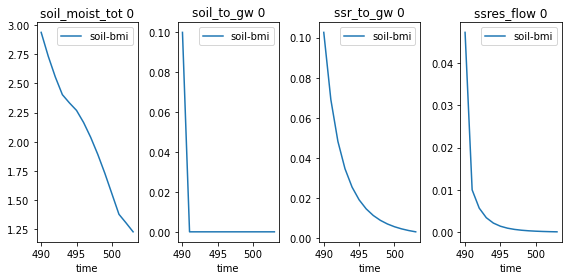

In [22]:
t_hru = 0
start_date = msoil.time-14
end_date = msoil.time
print(start_date, end_date)
import xarray as xr
soil_file = Path('../prms/pipestem/output/summary_soil_daily.nc')
dsoil = xr.open_dataset(soil_file,  decode_times=False)


fig, ax = plt.subplots(ncols=4, figsize=(8,4))
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist_tot', 'soil-bmi', start_date, end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'soil_to_gw', 'soil-bmi', start_date, end_date, ax[1])
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'ssr_to_gw', 'soil-bmi', start_date, end_date, ax[2])
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'ssres_flow', 'soil-bmi', start_date, end_date, ax[3])
plt.tight_layout()
plt.show()
